In [3]:
import pandas as pd
import ast
import numpy as np

# 文件路径
file_path = "/data1/public_data/mix_sft_64k/all.parquet"

# 1. 加载数据
try:
    df = pd.read_parquet(file_path)
except Exception as e:
    print(f"Error reading parquet file: {e}")
    # 为了演示，创建一个模拟的DataFrame
    data = {
        'id': ['1', '2', '3', '4', '5'],
        'context': [
            '...S3Provider.put_bucket_inventory_configuration...', 
            '...This is a math problem: x^2+2x+1=0...', 
            '...Define the term "reinforcement learning"...',
            '...Please implement a quick sort algorithm...',
            '...localstack.services.s3.v3.provider.S3Provider...'
        ],
        'question': [
            'Please complete the put_bucket_inventory_configuration function code.', 
            'Solve the quadratic equation.', 
            'What is reinforcement learning?',
            'Complete the quicksort function.',
            'Refactor the S3Provider class.'
        ],
        'metadata': [
            '{"task": "Code", "length": 26896, "source": "CoLT-132K"}',
            '{"task": "Math", "length": 1000, "source": "AIME"}',
            '{"task": "QA", "length": 500, "source": "Wiki"}',
            '{"task": "Code", "length": 5000, "source": "LeetCode"}',
            '{"task": "Code", "length": 3000, "source": "CoLT-132K"}'
        ],
        'answer': ['...code...', '...solution...', '...definition...', '...code...', '...code...'],
        'others': [np.array([{'key': '', 'value': ''}], dtype=object)] * 5
    }
    df = pd.DataFrame(data)
    print("Using mock DataFrame for demonstration.")


# 2. 从 metadata 字段中安全提取 'task'
def get_task(metadata_str):
    try:
        # metadata 通常是JSON字符串，需要安全地解析
        if isinstance(metadata_str, str):
            meta_dict = ast.literal_eval(metadata_str)
        elif isinstance(metadata_str, dict):
            meta_dict = metadata_str
        else:
            return None
        return meta_dict.get('task')
    except Exception:
        return None

df['task_type'] = df['metadata'].apply(get_task)

# 3. 筛选并查看任务分布
task_counts = df['task_type'].value_counts()
print("\n--- 任务类型分布 ---")
print(task_counts)

# 移除 task_type 为空或不常见的行，以便分析
df_clean = df.dropna(subset=['task_type'])


--- 任务类型分布 ---
task_type
Single QA        5860
MultiHop QA      5860
Summarization    2820
Code             1460
Name: count, dtype: int64


In [5]:
import pandas as pd
import ast

# 假设 df_clean 是您已经加载并解析了 'task_type' 的 DataFrame

def build_prompt_text(row):
    """
    根据您的 build_sft_input_and_labels 逻辑构造 prompt_text
    """
    ctx = row.get("context", "") or ""
    q = row.get("question", "") or ""
    meta = row.get("metadata", {}) or {}
    
    # 安全地解析 metadata 获取 flag
    try:
        if isinstance(meta, str):
            meta_dict = ast.literal_eval(meta)
        elif isinstance(meta, dict):
            meta_dict = meta
        else:
            meta_dict = {}
        flag = str(meta_dict.get("flag", "0"))
    except Exception:
        flag = "0" # 默认值

    # 逻辑实现
    if flag == "1":
        prompt_text = q
    else:
        if ctx and q:
            # 对应 ctx.rstrip() + "\n" + q.lstrip()
            # 简化处理：去除前后空白符，中间加换行
            prompt_text = ctx.strip() + "\n" + q.strip()
        else:
            # 对应 (ctx or q)
            prompt_text = (ctx or q)

    return prompt_text.strip()

# 1. 应用函数生成新的输入字段
df_clean['prompt_text'] = df_clean.apply(build_prompt_text, axis=1)

# 2. 准备新的文本和任务标签
texts_new = df_clean['prompt_text'].fillna('')
tasks_new = df_clean['task_type']

# 检查新字段的示例
print("--- 示例 prompt_text ---")
print(df_clean[['task_type', 'prompt_text']].head(2))

--- 示例 prompt_text ---
  task_type                                        prompt_text
0      Code  {"namespace": "localstack.services.s3.v3.provi...
1      Code  {"namespace": "sphinx.builders.html.Standalone...


/data1/anaconda3/envs/qqt/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


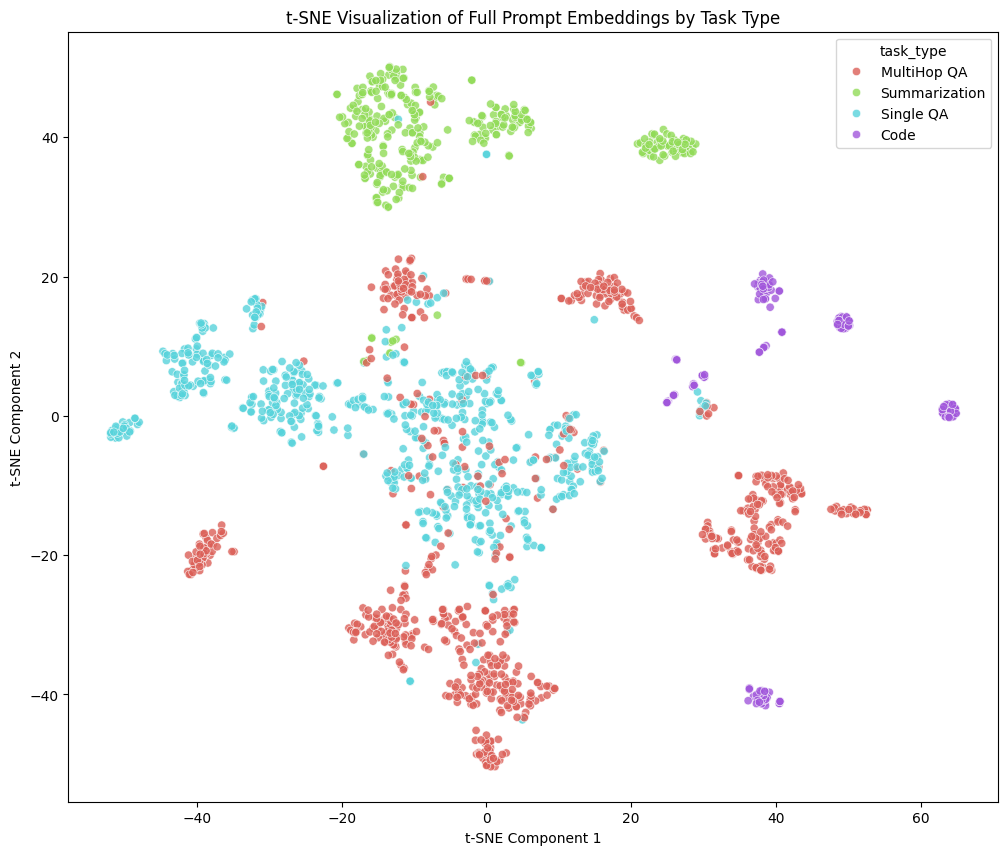

<module 'matplotlib.pyplot' from '/data1/anaconda3/envs/qqt/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. TF-IDF 向量化 (针对完整的 prompt_text)
# 保持参数不变，以确保可比性
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None)
X_new = vectorizer.fit_transform(texts_new)

# 2. 使用 PCA 降维
pca = PCA(n_components=50)
X_pca_new = pca.fit_transform(X_new.toarray())

# 3. 抽样
np.random.seed(42)
sample_size = min(len(X_pca_new), 2000)
sample_indices = np.random.choice(len(X_pca_new), sample_size, replace=False)

X_sample_new = X_pca_new[sample_indices]
tasks_sample_new = tasks_new.iloc[sample_indices]

# 4. t-SNE 降维 (注意：如果数据量大，需要耐心等待)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_new = tsne.fit_transform(X_sample_new)

# 5. 可视化
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=X_tsne_new[:, 0], y=X_tsne_new[:, 1],
    hue=tasks_sample_new,
    palette=sns.color_palette("hls", len(tasks_sample_new.unique())),
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Visualization of Full Prompt Embeddings by Task Type')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt

In [1]:
import pandas as pd
import os

# --- 之前读取的策略 ---
# 文件路径
file_path = "/data1/public_data/mix_sft_64k/all.parquet"

# 1. 加载数据
try:
    df = pd.read_parquet(file_path)
    print(f"成功加载文件：{file_path}，总行数：{len(df)}")

    # 2. 定义输出路径和文件名
    output_dir = "/data1/public_data/for_debug_mix_sft_64k/"
    output_file_name = "sample_100.parquet"
    output_path = os.path.join(output_dir, output_file_name)

    # 3. 检查输出目录是否存在，如果不存在则创建
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"已创建输出目录：{output_dir}")

    # 4. 随机采样100条数据
    # .sample(n=100) 用于从DataFrame中随机抽取n行
    if len(df) >= 100:
        sampled_df = df.sample(n=100, random_state=42) # 使用random_state确保结果可复现
        print(f"成功采样100条数据。")
        
        # 5. 保存采样结果到指定路径
        sampled_df.to_parquet(output_path, index=False) # index=False 不保存DataFrame的索引
        print(f"采样数据已成功保存到：{output_path}")
    else:
        print(f"警告：数据总行数不足100条 ({len(df)} 条)，将保存所有数据。")
        df.to_parquet(output_path, index=False)
        print(f"所有数据已保存到：{output_path}")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径：{file_path}")
except Exception as e:
    print(f"处理过程中发生错误：{e}")

成功加载文件：/data1/public_data/mix_sft_64k/all.parquet，总行数：16000
已创建输出目录：/data1/public_data/for_debug_mix_sft_64k/
成功采样100条数据。
采样数据已成功保存到：/data1/public_data/for_debug_mix_sft_64k/sample_100.parquet
